In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
import random
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [6]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer

from imutils import paths
from tensorflow.keras.preprocessing.image import load_img
from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import to_categorical

## Thuật toán NMS

In [7]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.5):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes are integers, convert them to floats -- this
	# is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes
	pick = []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	# compute the area of the bounding boxes and grab the indexes to sort
	# (in the case that no probabilities are provided, simply sort on the
	# bottom-left y-coordinate)
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	# if probabilities are provided, sort on them instead
	if probs is not None:
		idxs = probs

	# sort the indexes
	idxs = np.argsort(idxs)

	# keep looping while some indexes still remain in the indexes list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the index value
		# to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the largest (x, y) coordinates for the start of the bounding
		# box and the smallest (x, y) coordinates for the end of the bounding
		# box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]

		# delete all indexes from the index list that have overlap greater
		# than the provided overlap threshold
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	# return only the bounding boxes that were picked
	return boxes[pick].astype("int")

## Load Model

In [8]:
# Đường dẫn đến các model
MODEL_PATH_NEW = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/R-CNN_with_Raccoon/Model/raccoon_detector.keras'
ENCODER_PATH_NEW = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/R-CNN_with_Raccoon/Model/label_encoder.pickle'

model = load_model(MODEL_PATH_NEW)
lb = pickle.loads(open(ENCODER_PATH_NEW, "rb").read())

In [9]:
MAX_PROPOSALS = 300
MAX_POSITIVE = 30
MAX_NEGATIVE = 10
MIN_PROBA = 0.8
INPUT_DIMS = (224, 224)

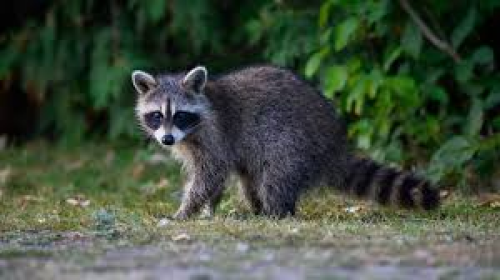

In [20]:
path_img = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/R-CNN_with_Raccoon/rc_test.jpg'
image = cv2.imread(path_img)
image = imutils.resize(image, width=500)

cv2_imshow(image)

In [9]:
!pip uninstall opencv-python opencv-contrib-python
!pip install opencv-contrib-python==4.5.5.64

Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/cv2/*
    /usr/local/lib/python3.10/dist-packages/opencv_python-4.10.0.84.dist-info/*
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Core-e6d3f451.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Gui-5dea4132.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Test-d435aae7.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Widgets-e392eaf8.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5XcbQpa-3bf8a55a.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libX11-xcb-0e257303.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libavcodec-9aae324f.so.59.37.100
    /usr/loca

[INFO] running selective search...
Total Number of Region Proposals: 842


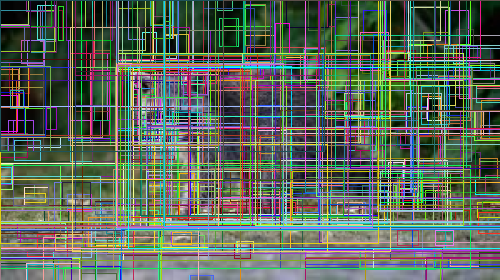

In [21]:
print("[INFO] running selective search...")

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

print('Total Number of Region Proposals: {}'.format(len(rects)))
img_selective = image.copy()

for (x, y, w, h) in rects:
  color = [random.randint(0, 255) for j in range(0,3)]
  cv2.rectangle(img_selective, (x, y), (x + w, y + h), color, 1)

cv2_imshow(img_selective)

In [22]:
proposals = []
boxes = []
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects[:MAX_PROPOSALS]:
    # extract the region from the input image, convert it from BGR to
    # RGB channel ordering, and then resize it to the required input
    # dimensions of our trained CNN
    img_roi = image.copy()

    roi = img_roi[y:y + h, x:x + w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, INPUT_DIMS, interpolation=cv2.INTER_CUBIC)
    # further preprocess the ROI
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    # update our proposals and bounding boxes lists
    proposals.append(roi)
    boxes.append((x, y, x + w, y + h))

[INFO] proposal shape: (300, 224, 224, 3)
[INFO] shape của Vùng đề xuất sau khi resize: (300, 224, 224, 3)
[INFO] 300 original bounding boxes


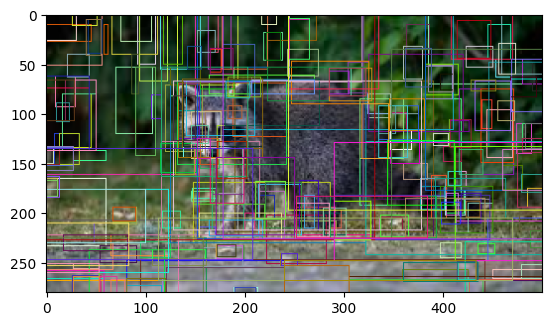

In [23]:
# clone the original image so that we can draw on it
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals.shape))

clone = image.copy()
print("[INFO] shape của Vùng đề xuất sau khi resize: {}".format(proposals.shape))

img_proposal = image.copy()

for (x, y, x2, y2) in boxes:
  color = [random.randint(0, 255) for j in range(0,3)]
  cv2.rectangle(img_proposal, (x, y), (x2, y2), color, 1)

plt.imshow(img_proposal[:, :, ::-1])
print("[INFO] {} original bounding boxes".format(len(boxes)))

In [24]:
print("[INFO] Nạp mô hình tinh chỉnh và file mã hóa nhãn, và gán nhãn cho Vùng đề xuất")
proba = model.predict(proposals)

[INFO] Nạp mô hình tinh chỉnh và file mã hóa nhãn, và gán nhãn cho Vùng đề xuất
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


In [31]:
print(proba)

[0.9820039  0.9793135  0.9746454  0.9739737  0.97346294 0.97337824
 0.966581   0.9649756  0.9646645  0.9630575  0.9616324  0.96106744
 0.94364434 0.9319513  0.9262046  0.90807706 0.90188164 0.87273246
 0.84266365 0.8407814 ]


In [25]:
# Tìm các dự đoán dương tính cho lớp "raccoon" với xác suất >= MIN_PROBA
labels = lb.classes_[np.argmax(proba, axis=1)]
idxs = np.where((labels == "raccoon") & (proba[:, 1] >= MIN_PROBA))[0]

# Lọc lại boxes và proba chỉ với các dự đoán "raccoon" đạt ngưỡng xác suất
boxes = boxes[idxs]
proba = proba[idxs][:, 1]

print("[INFO] Hộp giới hạn sau khi lọc: {}".format(boxes.shape))
print("[INFO] Xác suất dự đoán sau khi lọc: {}".format(proba.shape))


[INFO] Hộp giới hạn sau khi lọc: (20, 4)
[INFO] Xác suất dự đoán sau khi lọc: (20,)


Raccoon:97.35%
Raccoon:87.27%
Raccoon:96.31%
Raccoon:96.16%
Raccoon:96.66%
Raccoon:96.50%
Raccoon:97.34%
Raccoon:84.27%
Raccoon:84.08%
Raccoon:94.36%
Raccoon:97.46%
Raccoon:96.47%
Raccoon:90.81%
Raccoon:97.40%
Raccoon:98.20%
Raccoon:92.62%
Raccoon:96.11%
Raccoon:93.20%
Raccoon:90.19%
Raccoon:97.93%


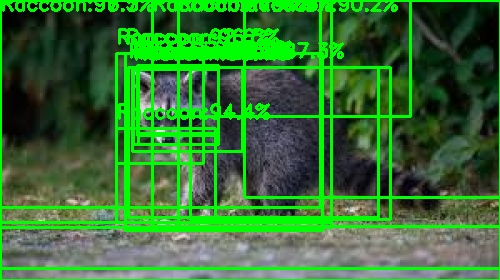

In [26]:
img_after_proposal = image.copy()  # Khởi tạo đúng vị trí

for (box, prob) in zip(boxes, proba):
    (startX, startY, endX, endY) = box
    # Vẽ hộp và nhãn
    cv2.rectangle(img_after_proposal, (startX, startY), (endX, endY), (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text = "Raccoon:{:.1f}%".format(prob * 100)
    cv2.putText(img_after_proposal, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)

# Giá trị xác suất
for (box, prob) in zip(boxes, proba):
    (startX, startY, endX, endY) = box
    print("Raccoon:{:.2f}%".format(prob * 100))

# Hiển thị ảnh
cv2_imshow(img_after_proposal)


[INFO] after non-maximum suppression: (4, 4)
Raccoon: 98.20%


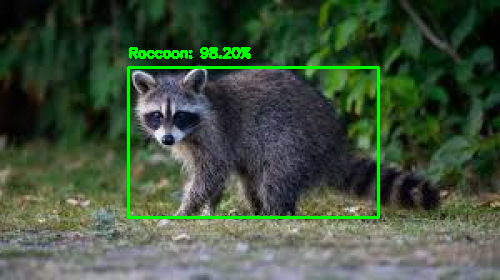

In [29]:
boxIdxs = non_max_suppression(boxes, proba, overlapThresh = 0.6)
print("[INFO] after non-maximum suppression: {}".format(boxIdxs.shape))

img_output = image.copy()

# Iterate through each element of boxIdxs
for i in boxIdxs.flatten(): # or boxIdxs.ravel()
    if 0 <= i < len(boxes):  # Check if index is within bounds
        # draw the bounding box, label, and probability on the image
        (startX, startY, endX, endY) = boxes[i]
        cv2.rectangle(img_output, (startX, startY), (endX, endY), (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        text = "Raccoon: {:.2f}%".format(proba[i] * 100)
        cv2.putText(img_output, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

print(text)

cv2_imshow(img_output)


In [28]:
# Sắp xếp boxes theo xác suất giảm dần
sorted_idxs = np.argsort(proba)[::-1]  # Sắp xếp xác suất giảm dần
boxes = boxes[sorted_idxs]
proba = proba[sorted_idxs]

print("[INFO] Xác suất dự đoán sau khi sắp xếp: {}".format(proba))

[INFO] Xác suất dự đoán sau khi sắp xếp: [0.9820039  0.9793135  0.9746454  0.9739737  0.97346294 0.97337824
 0.966581   0.9649756  0.9646645  0.9630575  0.9616324  0.96106744
 0.94364434 0.9319513  0.9262046  0.90807706 0.90188164 0.87273246
 0.84266365 0.8407814 ]


Text(0.5, 1.0, 'Output')

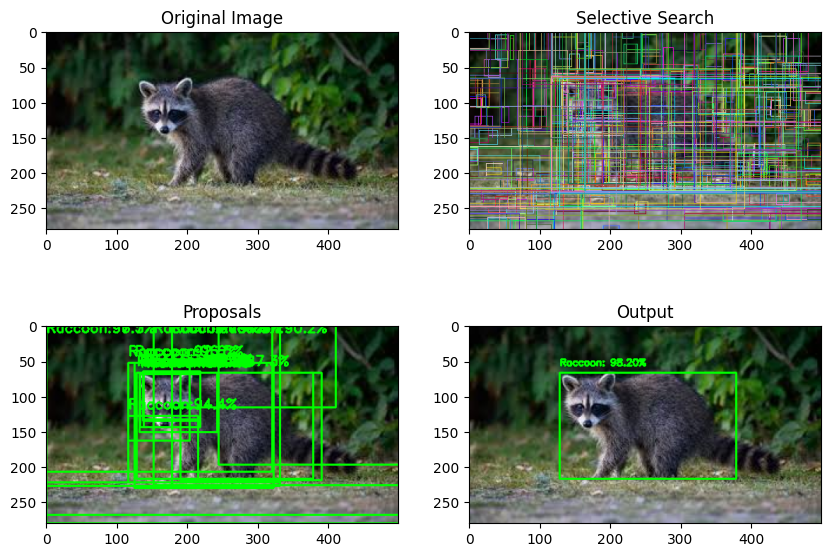

In [30]:
# Tổng hợp hình và hiện kết quả trong một khung hình
fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title("Original Image")

ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(cv2.cvtColor(img_selective, cv2.COLOR_BGR2RGB))
ax2.set_title("Selective Search")

ax4 = fig.add_subplot(2, 2, 3)
ax4.imshow(cv2.cvtColor(img_after_proposal, cv2.COLOR_BGR2RGB))
ax4.set_title("Proposals")

ax5 = fig.add_subplot(2, 2, 4)
ax5.imshow(cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB))
ax5.set_title("Output")

